<a href="https://colab.research.google.com/github/karthikmswamy/TF_Intro_Notebooks/blob/master/TF_DF_with_Data_Variations_Regression_News_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

In [ ]:
# !pip install -U augly
# !sudo apt-get install python3-magic
!pip install tensorflow_decision_forests
!pip install wurlitzer

## Imports

In [2]:
from time import time

import tensorflow_decision_forests as tfdf
import pandas as pd
import tensorflow as tf
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
import matplotlib.pyplot as plt

## Data Download and Check

In [3]:
!unzip train_news_sentiment.csv.zip

Archive:  train_news_sentiment.csv.zip
  inflating: train_news_sentiment.csv  
  inflating: __MACOSX/._train_news_sentiment.csv  


In [5]:
# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("./train_news_sentiment.csv", usecols=["Headline", "SentimentHeadline"])

# Display the first 3 examples.
dataset_df.head(3)

,Headline,SentimentHeadline
0,Obama Lays Wreath at Arlington National Cemete...,-0.053300
1,"Tim Haywood, investment director business-unit...",-0.156386
2,"Nouriel Roubini, NYU professor and chairman at...",0.139754


In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93239 entries, 0 to 93238
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Headline           93224 non-null  object 
 1   SentimentHeadline  93239 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.4+ MB


In [7]:
# Name of the label column.
label = "SentimentHeadline"

# classes = dataset_df[label].unique().tolist()
# print(f"Label classes: {classes}")

# dataset_df[label] = dataset_df[label].map(classes.index)

In [8]:
print(f"Number of records in dataframe: {len(dataset_df)}")

Number of records in dataframe: 93239


## Helper Methods

In [9]:
# Split the dataset into a training and a testing dataset.
# Test split remains a constant 
def split_dataset(dataset, num_train=10000):
  """Splits a panda dataframe in two."""
  dataset = dataset.sample(frac=1.0, random_state=1729)
  
  test_dataset = dataset[90000:]
  train_dataset = dataset[:num_train]
  
  return train_dataset, test_dataset

In [10]:
def train_rf_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.RandomForestModel(num_trees=30, task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

In [11]:
def train_gbdt_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=30,
                                                   task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

In [12]:
def train_cart_model_with_dataframes(train_df, test_df, label):
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, 
                                                     label=label, 
                                                     task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, 
                                                    label=label, 
                                                    task=tfdf.keras.Task.REGRESSION)

    # Specify the model.
    model_1 = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    model_1.compile(metrics=["mse"])

    t1 = time()
    # Train the model.
    with sys_pipes():
        model_1.fit(x=train_ds)

    evaluation = model_1.evaluate(test_ds, return_dict=True)

    print(f"MSE: {evaluation['mse']} in {time() - t1} secs")
    return evaluation['mse'], time() - t1

## Train with Different Records

In [13]:
def train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm):
    train_ds_pd, test_ds_pd = split_dataset(dataset_df, num_train)
    print(f"{len(train_ds_pd)} examples in training, {len(test_ds_pd)} examples for testing.")

    accuracy, time_taken = train_rf_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_rf.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_gbdt_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_gb.append([num_train, accuracy, time_taken])

    accuracy, time_taken = train_cart_model_with_dataframes(train_ds_pd, test_ds_pd, label)
    results_cm.append([num_train, accuracy, time_taken])

    return results_rf, results_gb, results_cm

In [14]:
results_rf, results_gb, results_cm = [], [], []
num_train_list = [500, 1000, 5000, 10000, 30000, 50000, 70000, 90000]
for num_train in num_train_list:
    results_rf, results_gb, results_cm = train_and_evaluate_on_data(num_train, results_rf, results_gb, results_cm)

500 examples in training, 3239 examples for testing.


2021-08-04 12:08:45.105294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-04 12:08:45.108505: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999995000 Hz


8/8 [==============================] - 4s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 500 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL has-dict vocab-size:1 num-oods:500 (100%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0276183 min:-0.616233 max:0.463713 sd:0.144971

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained thro

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.01992115005850792 in 7.066693305969238 secs
8/8 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 500 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL has-dict vocab-size:1 num-oods:500 (100%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0276183 min:-0.616233 max:0.463713 sd:0.144971

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained thro

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019917961210012436 in 0.3465244770050049 secs
8/8 [==============================] - 0s 2ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 8
[INFO kernel.cc:393] Number of examples: 500
[INFO data_spec_inference.cc:289] 500 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 500
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL has-dict vocab-size:1 num-oods:500 (100%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0276183 min:-0.616233 max:0.463713 sd:0.144971

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained thro

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019917961210012436 in 0.3907508850097656 secs
1000 examples in training, 3239 examples for testing.
16/16 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 999 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL has-dict vocab-size:1 num-oods:999 (99.9%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0265869 min:-0.616233 max:0.596004 sd:0.144593

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained 

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019918102771043777 in 0.5160074234008789 secs
16/16 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 999 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL has-dict vocab-size:1 num-oods:999 (99.9%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0265869 min:-0.616233 max:0.596004 sd:0.144593

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained 

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019918406382203102 in 0.508671760559082 secs
16/16 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 16
[INFO kernel.cc:393] Number of examples: 1000
[INFO data_spec_inference.cc:289] 999 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 1000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL has-dict vocab-size:1 num-oods:999 (99.9%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0265869 min:-0.616233 max:0.596004 sd:0.144593

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained 

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019918406382203102 in 0.4243648052215576 secs
5000 examples in training, 3239 examples for testing.
79/79 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO data_spec_inference.cc:289] 4976 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:1 (0.02%) has-dict vocab-size:1 num-oods:4976 (99.5399%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0291007 min:-0.616233 max:0.964646 sd:0.14287

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attrib

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019924994558095932 in 0.6668391227722168 secs
79/79 [==============================] - 0s 986us/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO data_spec_inference.cc:289] 4976 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:1 (0.02%) has-dict vocab-size:1 num-oods:4976 (99.5399%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0291007 min:-0.616233 max:0.964646 sd:0.14287

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attrib

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.01992759481072426 in 0.5423855781555176 secs
79/79 [==============================] - 0s 976us/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 79
[INFO kernel.cc:393] Number of examples: 5000
[INFO data_spec_inference.cc:289] 4976 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 5000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:1 (0.02%) has-dict vocab-size:1 num-oods:4976 (99.5399%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0291007 min:-0.616233 max:0.964646 sd:0.14287

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attrib

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.01992759481072426 in 0.5177645683288574 secs
10000 examples in training, 3239 examples for testing.
157/157 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO data_spec_inference.cc:289] 9894 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:1 (0.01%) has-dict vocab-size:1 num-oods:9894 (98.9499%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0289864 min:-0.755433 max:0.964646 sd:0.141995

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The at

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019926436245441437 in 0.6002175807952881 secs
157/157 [==============================] - 0s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO data_spec_inference.cc:289] 9894 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:1 (0.01%) has-dict vocab-size:1 num-oods:9894 (98.9499%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0289864 min:-0.755433 max:0.964646 sd:0.141995

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The at

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.01992684230208397 in 0.593928337097168 secs
157/157 [==============================] - 0s 996us/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 157
[INFO kernel.cc:393] Number of examples: 10000
[INFO data_spec_inference.cc:289] 9894 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 10000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:1 (0.01%) has-dict vocab-size:1 num-oods:9894 (98.9499%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0289864 min:-0.755433 max:0.964646 sd:0.141995

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The at

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.01992684230208397 in 0.6619422435760498 secs
30000 examples in training, 3239 examples for testing.
469/469 [==============================] - 0s 954us/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 469
[INFO kernel.cc:393] Number of examples: 30000
[INFO data_spec_inference.cc:289] 29092 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 30000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:5 (0.0166667%) has-dict vocab-size:5 num-oods:29092 (96.9895%) most-frequent:"<OOD>" 29092 (96.9895%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0279617 min:-0.755433 max:0.964646 sd:0.142968

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was 

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019919566810131073 in 1.6524064540863037 secs
469/469 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 469
[INFO kernel.cc:393] Number of examples: 30000
[INFO data_spec_inference.cc:289] 29092 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 30000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:5 (0.0166667%) has-dict vocab-size:5 num-oods:29092 (96.9895%) most-frequent:"<OOD>" 29092 (96.9895%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0279617 min:-0.755433 max:0.964646 sd:0.142968

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was 

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019918713718652725 in 1.61977219581604 secs
469/469 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 469
[INFO kernel.cc:393] Number of examples: 30000
[INFO data_spec_inference.cc:289] 29092 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 30000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:5 (0.0166667%) has-dict vocab-size:5 num-oods:29092 (96.9895%) most-frequent:"<OOD>" 29092 (96.9895%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0279617 min:-0.755433 max:0.964646 sd:0.142968

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was 

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019918719306588173 in 0.9971320629119873 secs
50000 examples in training, 3239 examples for testing.
782/782 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 782
[INFO kernel.cc:393] Number of examples: 50000
[INFO data_spec_inference.cc:289] 47676 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (27 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 50000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:9 (0.018%) has-dict vocab-size:28 num-oods:47676 (95.3692%) most-frequent:"<OOD>" 47676 (95.3692%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0273147 min:-0.755433 max:0.964646 sd:0.14269

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not

51/51 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019902149215340614 in 2.9028003215789795 secs
782/782 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 782
[INFO kernel.cc:393] Number of examples: 50000
[INFO data_spec_inference.cc:289] 47676 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (27 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 50000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:9 (0.018%) has-dict vocab-size:28 num-oods:47676 (95.3692%) most-frequent:"<OOD>" 47676 (95.3692%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0273147 min:-0.755433 max:0.964646 sd:0.14269

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019902309402823448 in 2.920426845550537 secs
782/782 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 782
[INFO kernel.cc:393] Number of examples: 50000
[INFO data_spec_inference.cc:289] 47676 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (27 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 50000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:9 (0.018%) has-dict vocab-size:28 num-oods:47676 (95.3692%) most-frequent:"<OOD>" 47676 (95.3692%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0273147 min:-0.755433 max:0.964646 sd:0.14269

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019903769716620445 in 1.5549368858337402 secs
70000 examples in training, 3239 examples for testing.
1094/1094 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 1094
[INFO kernel.cc:393] Number of examples: 70000
[INFO data_spec_inference.cc:289] 65872 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (80 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 70000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:12 (0.0171429%) has-dict vocab-size:81 num-oods:65872 (94.119%) most-frequent:"<OOD>" 65872 (94.119%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0272369 min:-0.755433 max:0.964646 sd:0.142281

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type wa

51/51 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019866393879055977 in 2.8978874683380127 secs
1094/1094 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 1094
[INFO kernel.cc:393] Number of examples: 70000
[INFO data_spec_inference.cc:289] 65872 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (80 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 70000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:12 (0.0171429%) has-dict vocab-size:81 num-oods:65872 (94.119%) most-frequent:"<OOD>" 65872 (94.119%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0272369 min:-0.755433 max:0.964646 sd:0.142281

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type wa

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019866928458213806 in 2.175100326538086 secs
   1/1094 [..............................] - ETA: 1:04WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0013s vs `on_train_batch_end` time: 0.0014s). Check your callbacks.


1094/1094 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 1094
[INFO kernel.cc:393] Number of examples: 70000
[INFO data_spec_inference.cc:289] 65872 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (80 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 70000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:12 (0.0171429%) has-dict vocab-size:81 num-oods:65872 (94.119%) most-frequent:"<OOD>" 65872 (94.119%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0272369 min:-0.755433 max:0.964646 sd:0.142281

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type wa

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.01991918869316578 in 1.7889947891235352 secs
90000 examples in training, 3239 examples for testing.
1407/1407 [==============================] - 2s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 1407
[INFO kernel.cc:393] Number of examples: 90000
[INFO data_spec_inference.cc:289] 83672 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (145 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 90000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:15 (0.0166667%) has-dict vocab-size:146 num-oods:83672 (92.9844%) most-frequent:"<OOD>" 83672 (92.9844%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0275329 min:-0.755433 max:0.964646 sd:0.141993

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the typ

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0198
MSE: 0.019840767607092857 in 5.470341444015503 secs
1407/1407 [==============================] - 2s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 1407
[INFO kernel.cc:393] Number of examples: 90000
[INFO data_spec_inference.cc:289] 83672 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (145 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 90000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:15 (0.0166667%) has-dict vocab-size:146 num-oods:83672 (92.9844%) most-frequent:"<OOD>" 83672 (92.9844%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0275329 min:-0.755433 max:0.964646 sd:0.141993

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the typ

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0198
MSE: 0.019841568544507027 in 2.7472193241119385 secs
1407/1407 [==============================] - 1s 1ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 1407
[INFO kernel.cc:393] Number of examples: 90000
[INFO data_spec_inference.cc:289] 83672 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Headline (145 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:769] Dataset:
Number of records: 90000
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "Headline" CATEGORICAL num-nas:15 (0.0166667%) has-dict vocab-size:146 num-oods:83672 (92.9844%) most-frequent:"<OOD>" 83672 (92.9844%)

NUMERICAL: 1 (50%)
	1: "__LABEL" NUMERICAL mean:-0.0275329 min:-0.755433 max:0.964646 sd:0.141993

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the typ

51/51 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0199
MSE: 0.019919967278838158 in 2.847332715988159 secs


## Plotting Results

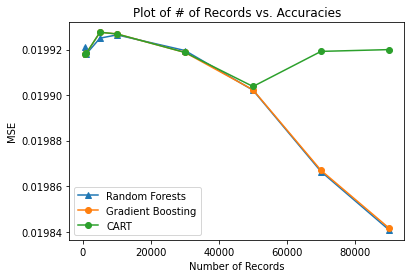

In [15]:
x  = [res[0] for res in results_rf]
y1 = [res[1] for res in results_rf]
y2 = [res[1] for res in results_gb]
y3 = [res[1] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("MSE")
plt.title("Plot of # of Records vs. Accuracies")
plt.legend()
plt.show()

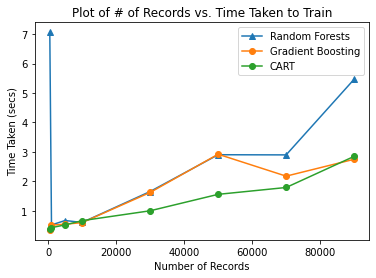

In [16]:
x  = [res[0] for res in results_rf]
y1 = [res[2] for res in results_rf]
y2 = [res[2] for res in results_gb]
y3 = [res[2] for res in results_cm]
plt.plot(x, y1, label="Random Forests", marker='^')
plt.plot(x, y2, label="Gradient Boosting", marker='o')
plt.plot(x, y3, label="CART", marker='o')
plt.plot()

plt.xlabel("Number of Records")
plt.ylabel("Time Taken (secs)")
plt.title("Plot of # of Records vs. Time Taken to Train")
plt.legend()
plt.show()

In [17]:
results_rf

[[500, 0.01992115005850792, 7.067541122436523],
 [1000, 0.019918102771043777, 0.5161306858062744],
 [5000, 0.019924994558095932, 0.6669690608978271],
 [10000, 0.019926436245441437, 0.6003003120422363],
 [30000, 0.019919566810131073, 1.6530916690826416],
 [50000, 0.019902149215340614, 2.9035227298736572],
 [70000, 0.019866393879055977, 2.897979259490967],
 [90000, 0.019840767607092857, 5.470456600189209]]

In [18]:
results_cm

[[500, 0.019917961210012436, 0.39173388481140137],
 [1000, 0.019918406382203102, 0.4253082275390625],
 [5000, 0.01992759481072426, 0.5178916454315186],
 [10000, 0.01992684230208397, 0.6620454788208008],
 [30000, 0.019918719306588173, 0.997779369354248],
 [50000, 0.019903769716620445, 1.5566558837890625],
 [70000, 0.01991918869316578, 1.7897381782531738],
 [90000, 0.019919967278838158, 2.8481051921844482]]

In [19]:
results_gb

[[500, 0.019917961210012436, 0.3472609519958496],
 [1000, 0.019918406382203102, 0.5087885856628418],
 [5000, 0.01992759481072426, 0.5425302982330322],
 [10000, 0.01992684230208397, 0.5948545932769775],
 [30000, 0.019918713718652725, 1.6206111907958984],
 [50000, 0.019902309402823448, 2.920558452606201],
 [70000, 0.019866928458213806, 2.1752171516418457],
 [90000, 0.019841568544507027, 2.7491180896759033]]